In [115]:
import os
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
import matplotlib.pyplot as plt

In [116]:
data = pd.read_csv('DummiesV2.csv')

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [118]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Normalized confusion matrix"
    else:
        title = title if title else "Raw confusion matrix"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Avec une régression logistique

### Non-équilibrée

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

retrain = False
if not os.path.isfile('regression-log-unbalanced.joblib') or retrain:
    ULR = LogisticRegression(multi_class='multinomial', max_iter=1000)
    selector_ULR = RFECV(ULR, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_ULR, 'regression-log-unbalanced.joblib')
else:
    selector_ULR = jl.load('regression-log-unbalanced.joblib')

ULR = selector_ULR.estimator_

In [120]:
selected_ULR = [variable for variable, boolean in zip(X.columns.tolist(), selector_ULR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(ULR.predict(X_test[selected_ULR]) == Y_test))

Accuracy : 0.6493888637392485


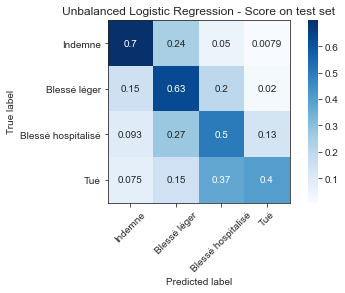

In [121]:
from sklearn import metrics
conf = metrics.confusion_matrix(ULR.predict(X_test[selected_ULR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Logistic Regression - Score on test set');

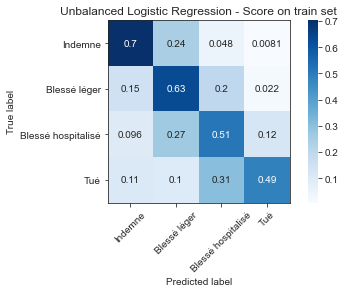

In [122]:
conf = metrics.confusion_matrix(ULR.predict(X_train[selected_ULR]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Logistic Regression - Score on train set');

### Equilibrée

In [123]:
retrain = False
if not os.path.isfile('regression-log-balanced.joblib') or retrain:
    BLR = LogisticRegression(multi_class='multinomial', max_iter=1000, class_weight='balanced')
    selector_BLR = RFECV(BLR, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_BLR, 'regression-log-balanced.joblib')
else:
    selector_BLR = jl.load('regression-log-balanced.joblib')

BLR = selector_BLR.estimator_

In [124]:
selected_BLR = [variable for variable, boolean in zip(X.columns.tolist(), selector_BLR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BLR.predict(X_test[selected_BLR]) == Y_test))

Accuracy : 0.5851063829787234


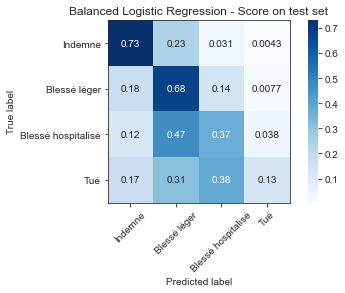

In [125]:
conf = metrics.confusion_matrix(BLR.predict(X_test[selected_BLR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Logistic Regression - Score on test set');

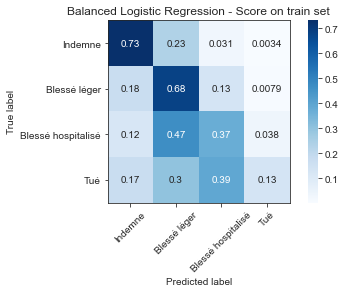

In [126]:
conf = metrics.confusion_matrix(BLR.predict(X_train[selected_BLR]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Logistic Regression - Score on train set');

# Avec un Random Forest

### Non-équilibré

In [127]:
from sklearn.ensemble import RandomForestClassifier

retrain = False
if not os.path.isfile('randomforest-unbalanced.joblib') or retrain:
    URF = RandomForestClassifier()
    selector_URF = RFECV(URF, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_URF, 'randomforest-unbalanced.joblib')
else:
    selector_URF = jl.load('randomforest-unbalanced.joblib')

URF = selector_URF.estimator_

In [128]:
selected_URF = [variable for variable, boolean in zip(X.columns.tolist(), selector_URF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(URF.predict(X_test[selected_URF]) == Y_test))

Accuracy : 0.6550726824606408


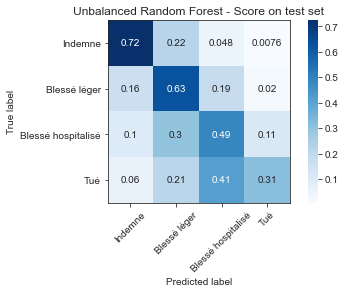

In [129]:
conf = metrics.confusion_matrix(URF.predict(X_test[selected_URF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Random Forest - Score on test set');

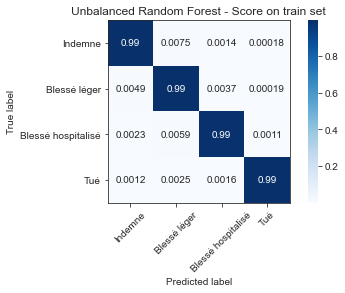

In [130]:
conf = metrics.confusion_matrix(URF.predict(X_train[selected_URF]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Random Forest - Score on train set');

### Equilibré

In [131]:
retrain = False
if not os.path.isfile('randomforest-balanced.joblib') or retrain:
    BRF = RandomForestClassifier(class_weight='balanced')
    selector_BRF = RFECV(BRF, cv=StratifiedKFold(2), scoring="accuracy", step=1).fit(X_train, Y_train)
    jl.dump(selector_BRF, 'randomforest-balanced.joblib')
else:
    selector_BRF = jl.load('randomforest-balanced.joblib')

BRF = selector_BRF.estimator_

In [132]:
selected_BRF = [variable for variable, boolean in zip(X.columns.tolist(), selector_BRF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BRF.predict(X_test[selected_BRF]) == Y_test))

Accuracy : 0.6557768723907248


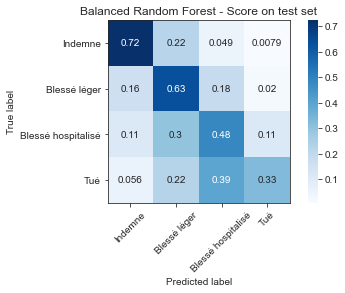

In [133]:
conf = metrics.confusion_matrix(BRF.predict(X_test[selected_BRF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Random Forest - Score on test set');

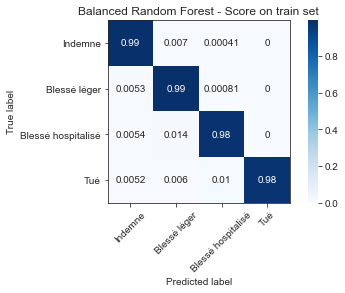

In [134]:
conf = metrics.confusion_matrix(BRF.predict(X_train[selected_BRF]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Random Forest - Score on train set');

# Variables éliminées par les différents modèles

### Par la régression linéaire

In [135]:
for mod in data.columns.tolist():
    if mod not in targets and mod not in selected_BLR:
        print(mod)

Gilet réflechissant
Airbag
Sens de circulation décroissant
Engin spécial
Obstacle : Parapet
Dans le couloir de bus, même sens
En dépassant
Propulsion humaine
Intersection en X
Intersection en T
Intersection à plus de 4 branches
Passage à niveau
Autre intersection
Pluie forte
Neige ou grêle
Brouillard ou fumée
Autres conditions atmosphériques
Parc de stationnement
Route en pente
Surface mouillée
Chaussée inondée
Chaussée enneigée
Chaussée boueuse
Chaussé verglacée
Présence d'un corps gras sur la chaussée
Autre état de la chaussée
Souterrain, tunnel
Chantier
Sur bande d'arrêt d'urgence
Vitesse limitée à 70km/h
Vitesse limitée à 90km/h
Vitesse limitée à 60km/h
Vitesse limitée à 15km/h
Vitesse limitée à 40km/h
Vitesse limitée à 45km/h
Vitesse limitée à 100km/h
40-59ans
3 voies de circulation
4 voies de circulation
9 voies de circulation
11 voies de circulation


### Par le random forest

In [136]:
for mod in data.columns.tolist():
    if mod not in targets and mod not in selected_BRF:
        print(mod)

Dans le couloir de bus, contresens
Chaussée inondée
Chaussée boueuse
Vitesse limitée à 15km/h
Vitesse limitée à 45km/h
Vitesse limitée à 25km/h
Vitesse limitée à 100km/h
Vitesse limitée à 65km/h
Vitesse limitée à 120km/h
Vitesse limitée à 35km/h
11 voies de circulation
12 voies de circulation
